In [8]:
import pandas as pd
import re
charge_points = pd.read_csv("../data/interim/chargepoints_full.csv")

In [9]:
charge_points.columns

Index(['lsoa11cd', 'lsoa11nm', 'msoa11cd', 'msoa11nm', 'ladcd', 'ladnm',
       'pcds', 'region', 'oa11cd', 'Address_ID', 'Address_Title',
       'AddressLine1', 'AddressLine2', 'Town', 'StateOrProvince', 'Postcode',
       'CountryID', 'Country', 'Latitude', 'Longitude', 'ContactTelephone1',
       'ContactTelephone2', 'ContactEmail', 'AccessComments', 'RelatedURL',
       'Distance', 'DistanceUnit', 'charge_points', 'date_created',
       'WebsiteURL', 'Comments', 'PhonePrimaryContact',
       'PhoneSecondaryContact', 'IsPrivateIndividual', 'AddressInfo',
       'BookingURL', 'ContactEmail.1', 'FaultReportEmail', 'IsRestrictedEdit',
       'Operator_ID', 'Operator_Title', 'IsOperational', 'IsUserSelectable',
       'Status_ID', 'Status_Title', 'IsPayAtLocation', 'IsMembershipRequired',
       'IsAccessKeyRequired', 'Usage_ID', 'Usage_Title', 'general_comments'],
      dtype='object')

### Statistics on the number of chargepoint locations, number of chargers per location and percentage of operational chargers

In [10]:
more_chargers = charge_points[charge_points['Address_Title'].notna()].drop_duplicates().reset_index(drop=True)
print(f"Number of charging stations: {more_chargers.shape[0]} ")
print(f"Number of charge points: {more_chargers['charge_points'].sum():.0f} ")
print(f"charge points per charging station: {more_chargers['charge_points'].sum()/more_chargers.shape[0]:.0f} ")
print(f"% of chargepoints operable: {more_chargers['IsOperational'].value_counts(normalize=True)[1]*100:.1f}")

Number of charging stations: 6216 
Number of charge points: 19582 
charge points per charging station: 3 
% of chargepoints operable: 98.0


In [1100]:
def get_location_genre(driver,search_text):
    driver.find_element_by_id('query-input').clear()
    driver.find_element_by_id('query-input').send_keys(search_text)
    driver.find_element_by_id('geocode-button').send_keys(u'\ue007')

    time.sleep(1)

    data = driver.find_element_by_id('results-display-div').text
    return re.search(r'Types:(.*)\n',data).group(1).strip().replace(" ","").split(",")

In [1098]:
#Importing selenium to extract location categories from given url
from selenium.webdriver import Chrome
import pandas as pd
import time
import requests
from bs4 import BeautifulSoup

webdriver = "chromedriver.exe"
driver = Chrome(webdriver)

url = "https://google-developers.appspot.com/maps/documentation/utils/geocoder/"

driver.get(url)
time.sleep(1)
driver.find_element_by_id('show-options-link').click()
driver.find_element_by_xpath('//*[@id="bias-country-select"]/option[234]').click()

In [1099]:
#genre_list = {} #This is initialised for empty dictionary to be filled with categories of charger locations
for row,col in more_chargers.iloc[6000:6001,:].iterrows():
    search_text =""
    if type(col['Address_Title'])== str:
        search_text = search_text+col['Address_Title']
    else:
        search_text = search_text+""
    
    if type(col['AddressLine1'])== str and type(col['Address_Title'])== str:
        search_text = search_text+", "+col['AddressLine1']
    elif type(col['AddressLine1'])== str:
        search_text = search_text+col['AddressLine1']
    else:
        search_text = search_text+""
    '''
    if type(col['AddressLine2']) == str and (type(col['AddressLine1'])== str or type(col['Address_Title'])== str):
        search_text = search_text+", "+col['AddressLine2']
    elif type(col['AddressLine2']) == str and (type(col['AddressLine1'])!= str and type(col['Address_Title'])!= str):
        search_text = search_text+col['AddressLine2']
    else:
        search_text = search_text+""
    
    search_text = search_text+", "+col['Postcode']
    
    '''
    genre_list[row] = get_location_genre(driver,search_text)

In [ ]:
#List of indexed items that returned no result
'''trouble_list = [233,252,374,445,702,773,774,1152,1414,1418,1604,1706,1711,1789,2501,2562,2813,2957,3194,3761,3888,4040,
            4319,4827,5201,6090]'''

In [1101]:
#Saving genre_list to csv
pd.DataFrame.from_dict(genre_list,orient='index').to_csv("categorize.csv")

In [1043]:
#Filling None data with empty string
categories = pd.DataFrame.from_dict(genre_list,orient='index').sort_index().fillna("")

#Attaching multiple genre words to a single string expression
categories = categories.applymap(lambda x : " "+x+" ").sum(axis=1)
categories = categories.map(lambda x : x.strip())

In [1044]:
#Using count vectorizer to extract google location genres
from sklearn.feature_extraction.text import CountVectorizer

cvec = CountVectorizer(max_features=120)

cat_list = pd.DataFrame(cvec.fit_transform(categories).toarray(),columns=cvec.get_feature_names())



In [1046]:
#Creating function to merge google genre words to larger defined words
def merge_groups(df,new_name,*arg):
        
    df[new_name] = df[[x for x in arg]].sum(axis=1)
    df[new_name] = df[new_name].apply(lambda x : 1 if x >= 1 else 0)
    df = df.drop([x for x in arg],axis=1)
    return df

In [1047]:
cat_list = merge_groups(cat_list,'premises','premise','subpremise')
cat_list = merge_groups(cat_list,'grocery_supermarket_pharmacy','grocery_or_supermarket','supermarket','pharmacy')
cat_list = merge_groups(cat_list,'car_dealers_repair_wash','car_dealer','car_repair','car_wash')
cat_list = merge_groups(cat_list,'public_transport','transit_station','train_station','subway_station','bus_station','light_rail_station')
cat_list = merge_groups(cat_list,'food_restaurant_bar_cafe','restaurant','bar','cafe','food','meal_takeaway','bakery')
cat_list = merge_groups(cat_list,'street_parking','route','street_address','intersection')
cat_list = merge_groups(cat_list,'health_spa_gym','health','spa','gym','doctor','dentist')
cat_list = merge_groups(cat_list,'university_school','university','school','secondary_school','primary_school')
cat_list = merge_groups(cat_list,'retail','store','convenience_store','clothing_store','home_goods_store','furniture_store',
                        'department_store','electronics_store','shopping_mall','jewelry_store','pet_store',
                        'shoe_store','liquor_store','book_store','hardware_store','bicycle_store')
cat_list = merge_groups(cat_list,'banks','finance','atm','bank')
cat_list = merge_groups(cat_list,'emergency_services','hospital','police','fire_station')
cat_list = merge_groups(cat_list,'business','general_contractor','real_estate_agency','travel_agency','beauty_salon',
                        'hair_care','car_rental','storage','accounting','insurance_agency','plumber','electrician',
                        'roofing_contractor','lawyer','florist','laundry','moving_company','veterinary_care')
cat_list = merge_groups(cat_list,'parks_attractions','tourist_attraction','campground','rv_park','park','zoo',
                        'movie_theater','amusement_park','stadium','casino','night_club','aquarium','natural_feature')
cat_list = merge_groups(cat_list,'library_museum','museum','library','art_gallery')
cat_list = merge_groups(cat_list,'government_public','local_government_office','political','locality','city_hall','post_office','embassy')
cat_list = merge_groups(cat_list,'religious_location','place_of_worship','church','cemetery')
cat_list = merge_groups(cat_list,'administrative_area','administrative_area_level_4','postal_code','postal_code_prefix')
cat_list = merge_groups(cat_list,'other','colloquial_area','neighborhood')

In [1113]:
import matplotlib.pyplot as plt
import seaborn as sns

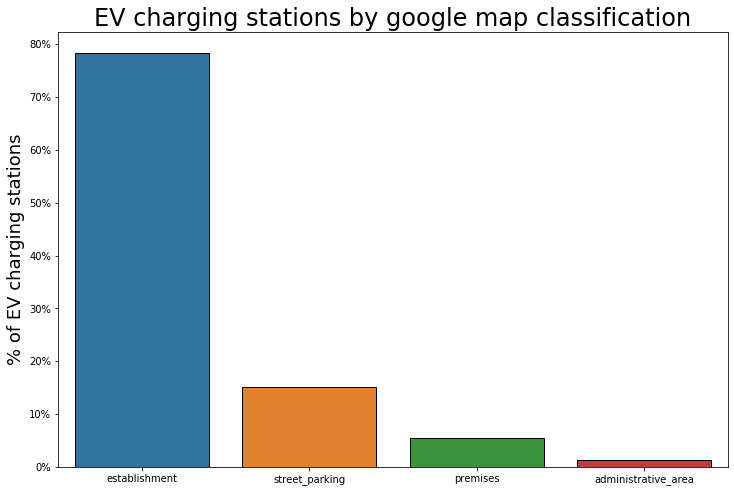

In [1191]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=cat_list[['establishment','street_parking','premises','administrative_area']],estimator=np.mean,ci=None, ec='k')
ax.set_title(
    "EV charging stations by google map classification", fontsize=24)
#ax.set_xlabel("EV charging stations location", fontsize=18)
ax.set_ylabel("% of EV charging stations", fontsize=18)

plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.savefig("../reports/figures/EV_charging_stations_breakdown.jpg");

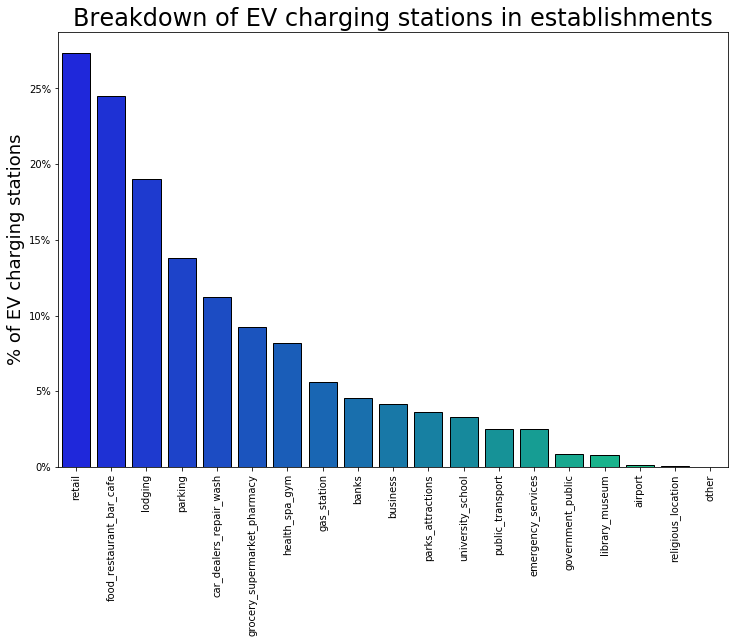

In [1190]:
fig, ax = plt.subplots(figsize=(12, 8))
est_breakdown = cat_list[cat_list['establishment']==1].drop(['establishment','point_of_interest','street_parking','premises','administrative_area'],axis=1)
est_breakdown_order = est_breakdown.sum().sort_values(ascending=False).index
sns.barplot(data=est_breakdown,estimator=np.mean,order=est_breakdown_order,ci=None, orient='v', palette='winter', ec='k')

ax.set_title(
    "Breakdown of EV charging stations in establishments", fontsize=24)
#ax.set_xlabel("EV charging stations location", fontsize=18)
ax.set_ylabel("% of EV charging stations", fontsize=18)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.xticks(rotation=90)
plt.savefig("../reports/figures/EVlocation_chart.jpg");

In [137]:
health_list= ['Carnival Pool','Thornaby Pool','Wyboston Lakes Leisure Club','Roehampton Club','Ashton Pool',
              'Hereford Leisure Pool', 'Tolworth Sports Ground', 'Spindlewood', 'Etihad Velodrome Cycling Arena']

hotel_list = ['Bagshaw Hall', 'Milsoms Kesgrave Hall ', 'Wyboston Lakes', 'Whitelee Holiday Cottages', 'Earl of Chatham',
              'County Arms', 'Barnsdale Lodge', 'Hexham', 'Hexham','Allen Mills Allendale', 'Castle Lodge',
              'Bourne Leisure','Kings Chamber','The Lygon Arms','The Carrington Arms','The Miners Arms',
              'Shireburn Arms','The Devonshire Arms At Pilsley','The Devonshire Arms At Beeley','The Old Rectory',
             'The Old Piggery','Old Barn','The Old Parsonage','Fairfield the Old Rectory']


park_list = ['Uea', 'Brook Green', 'South Downs Centre, Midhurst','Summerland Gardens, Haringey',
             "Westminster-Lincoln's Inn Fields", 'Minsmere RSPB','Allianz Park','Buckmore Park Kart Circuit',
             'Waterside Holiday Park & Spa','Mill Park Caravan & Camping','Horton Park Golf Course',
             'Upwood Holiday Park','The Park Cornwall','Clarence Park Village']
parking_list = ['City of London Corporation','Temple Gate','Indigo West India Quay','Oldham Mumps', 'Source West HQ',
                'Esam Building', 'Scarles Yard', 'St. Ives Cattle Market', 'Marine Walk', 'Northumberland Park Metro',
                'Curzon Place, NG3 1DJ','Linford Forum', "Bede's World", 'Hartlepool Transport Interchange',
                'Doctors Nook Pay and Display','1 Trinity Green', 'Ram Meadow']
govt_list = ['Borough Hall','Hmp Belmarsh','DSS Department of Works and Pensions','Enivronment Agency Ely',
             'Highways England: Regional Control Centre (Eastern)']

education_list = ['RHS of security building', 'Two Mile Ash', 'NETA Training']
dealer_list = ['Motorline Tunbridge Wells', 'Benfield Motors', 'Greenhous Group Shrewsbury', 'PSA Groupe-Coventry',
               'Dealership forecourt', 'Vines of Guildford', 'Blights Motors']
service_list = ['West Way Southampton', 'Prince Rock Depot', 'Stanleys of Marden', 'Trevissome Park, Blackwater - Cornwall',
                'MG Cannon-Dorchester', 'Eurovans Crawley', 'Frosts Accident Repairs', 'M & A Coachworks','BTN Turbo',
                'Hereford Auto Repair', 'Ionity Maidstone', 'Jet - Apollo','The Old Dairy','The AA Oldbury']
residential_list = ['Turnberry Quay', 'Merchants Quay', 'Redrow Colindale', 'Barnet House e-Car', 'Your Homes Newcastle',
                    'Eventus', ' Centro House Birmingham', 'Enappsys', 'Westbrook Developments', 'Holloway Hub', 'N/A',
                    'Little Hivings','Foxes Piece',
                    'Roper Yard']

retail_list = ['London-Brent Cross', 'Secklow Gate', 'Elder Gate', '300 Saxon Gate', 'Spinning Gate Pay and Display',
               'Currys Digital', 'Ashbury Chocolates', 'LG Stevenage', 'Jaeger Store', 'J Leon Group',
               'Newcastle Upon Tyne', 'York Designer Outlet', 'Lowry Outlet - Salford', 'Housing Units',
               'Housing Association-Ccurv', 'Stockton On Tees','Cauldwell Property',
               "Silbury Blvrd - behind Curry's Digital", 'Jewellery Quarter','Xscape', 'Petersfinger, Salisbury',
               'Locks Heath Shopping Village','Harrods', 'Soundstage Hi-Fi & Home Cinema','Esher', "Weaver's Wharf",
              'B&Q Pavilion Park, Brighton']

entertain_list = ['Clevedon Hall','Grafton Gate East','Ruddy Duck','City of Bradford MDC','Webbs of Wychbold',
                  'Energi Trampoline Park-York','Holmbush Inn St. Austell','Chestnut Tree','Spread Eagle Pub & Restaurant',
                  'Sondes Arms Rockingham','East Bar Lounge Grill','Tobacco Factory','Poppy Fields','Wythenshawe Forum',
                  'Cams Mill','Anglo Management Music','Ace Cafe','Eventus','Network Rail Westwood','Brooklands',
                  'Route 303 Café','Marine Walk','Red Sails', 'Silverstone Circuit Rapid','Chateau Impney','Battlesteads',
                  'Hanley Farm Shop','Falstone Tea Rooms','Toby Cavery','Harvester Didcot','Hinton Arms','Montague Arms',
                  'Waddington Arms','The Bewicke Arms and Hare Pie Rooms','The Wellington Arms','The Gardeners Arms',
                  'The Queens Arms','The Blacksmiths Arms','The Duncombe Arms','The Duncombe Arms Waresley','The Manor Arms',
                 'Old Green Dragon']

business_list = ['International Quarter London','Urban Planters-London West','Bill Quay Farm','Marlow International',
                 'Marlec Engineering Corby','Maurice Wilkes Building','Pepsico','Travel Port','Citizens Advice Bureau',
                 'Cobalt Business Exchange','Hitachi Capital Vehicle Solutions','Project Oxygen 4','Visteon',
                 'Capital Space','Ceres Power','Bury Market','RGB Group','British Standards Institute, Hounslow',
                 'British Antarctic Survey (strictly For Employees and Visitors Use Only)','Staniland Marina',
                 'Podpoint British Standards Institute','Podpoint Hitachi Trowbridge - A','Big Yellow Self Storage',
                 'Fergyspace Self Store','Holborn Studios','Northern Counties Safety Group','Electric Center Staples Corner',
                 'Islamic Relief UK','Sunseeker Poole','Kings Place Management','Cannon Workshops','White Collar Factory',
                 '76 Upper Ground', 'Shenley Pavilions', 'Motability Bristol', 'Octink','Lanchester Wines','Campbell','Vickery Holman',
                 'Larkenergy','BT','Berghaus','Lex Autolease','Hitachi Newbury','Island Site','WCM Europe','Pomona',
                 'Pentland Brands','Dornan Engineering','Ascertiva','Phoenix Taxis','DE55 5JY','Bizzy Bees Buses',
                 'Silver Birch','Complete Interior Design','Avensys','Ald Automotive','Ford Reception','Penton Hook Marina',
                 'Dolphin Living', 'Bytesnap','Liquid 11, Lowestoft', 'Larkfleet Homes','EC Williams Specialist Electroplaters',
                 'BPTW Partnership','Evolution Enabling-Greenwich','Sond Construction','General Electric','Tropical Sky'
                'Thorpe Park Leeds','Oxford Science Park-Schrodinger Building','Capital Park Cambridge','River Park Avenue, Staines'
                 ,'Monkey Park Community Interest Company','Old Barn Tregonetha']

street_list = ['Concert Hall Approach','Lancaster Gate',"Queen's Gate",'Exchange Quay','Boston Vale','Victoria Villas',
               'Open View','Straightsmouth','Strand on Green','Brunel Way Rapid Charger','Comet Croydon',
               'Crescent House Lay By','Bus rapid charger','Shepherds Walk','Goldhurst Terrace','Cleveland Terrace',
               'Palace Gardens Terrace','Lamp Column 6','Lamp Column 7','Dryburn View','Broughton Hub',
               'Charlwood St. Between Vauxhall Bridge RD and Tachbrook St','South Parade','Clifton Villas',
               'Pembroke Villas','Princes Avenue, Haringey','Burlington House ','Central Parade','North Burns',
               'Clapham Common North Side','Opposite 195','Montagu Mansions','Old Orchard','Lamp Post Charger',
               ' Perkins Engines','Howardsgate','XQ7','Bigg Market','Richmond Way W14','Hammersmith Bridge',
               'Highbury Quadrant','Bushey Arches','Kestrel Avenue, Lambeth','Commondale','Walthamstow',
               'Vision Devonport Development','Fergusson Mews','Acton 6.1','128 Roehampton Vale','New Wanstead',
               'Chelsea Embankment','EE Paddington','Ubitricity Clarendon Cross']

### Categorizing some chargepoint location based on title name

In [165]:
more_chargers['type'] = more_chargers['Address_Title'].apply(lambda x : 'Supercharger' if re.search(r"(supercharger|charging station|northbound)",x.lower()) != None
                                                  else 'Hotel' if re.search(r"hotel|guest.*house|belfry|radisson|premier inn|holiday inn|travelodge|ibis|crowne plaza|hilton|suites|black horse inn|the berkeley|cow dalbury|(the (ashleigh|raffles|camberley|bijou|pig in the)|novotel|best western|hostel|lodges|cottages|b&b|bed & breakfast|bed and breakfast|lodge|forest holidays| hall| inn|barn)",x.lower()) != None
                                                    else 'Hotel' if x in hotel_list
                                                  
                                                  else 'Supermarket' if re.search(r"(supermarket|superstore|marks.*spencer|co-op|morrisons|sainsbury|tesco|asda|lidl|waitrose|booths|aldi.?|hoover build|iceland|m&s|costco)",x.lower()) != None
                                                  else 'Parking' if re.search(r"(car.?park)|(park.*ride)|(parking)|(ncp| cp|gilead street,|east parkside|hill - hawk|canary wharf|nw06-alto|queens drive compound|cabot circus|bourne hill|weavers court|valley view|dn22 6eu|multi storey|upper st leonardgate|north row|citipark|northumberlandia)",x.lower()) != None
                                                  else 'Parking' if x in parking_list
                                                  
                                                  else 'Retail' if re.search(r"((retail|business).?park)|(shopping.*(mall|centre))|westfield|ikea|, worksop|mscp|southgate bath|sofaworks|next new malden|debenhams|outside |ev experience|clifton triangle|victoria gate|bullring|foods|trafford centre|octagon multistorey|smithfield |meadway park| mall |the nook|(wadesmill|parsons|burners) lane|currys|dhl|halfords",x.lower()) != None
                                                  else 'Retail' if x in retail_list
                                                  
                                                  else 'Park' if re.search(r"(park$|gardens$|q.?park|playground |parsons green|parks trust|campbell park|park avenue-sunbury|the green|eden project|marlborough lane|sea winnings|monkton stadium|ev driver|farm|club)",x.lower()) != None
                                                  else 'Park' if x in park_list
                                                  
                                                  else 'Car Dealer' if re.search(r"(bristol.*motors)|(nissan|volkswagen|renault|bmw|mercedes|hyundai|peugeot|toyota|volvo|jaguar|ford motor|cordwallis|currie motors|autocentre|wessex garages|suzuki| autos|dealership|mitsubishi|motorbodies|richard sanders|vospers|glynn hopkins|citroen|desira )",x.lower()) != None
                                                  else 'Car Dealer' if x in dealer_list
                                                  
                                                  else 'Service Station' if re.search(r"( services)|((service|filling|gas|petrol|fuel).?station)|(shell|mfg|bp\s|esso\s|texaco|euro.?garages|nomadpower|welcome break|garage|coachway ionity|highway depot|moto |motofix)",x.lower()) != None
                                                  else 'Service Station' if x in service_list
                                                  
                                                  else 'Health' if re.search(r"((health|leisure|sports|golf|tennis|nhs|dental).*(centre|foundation))|(hospital|infirmary|village practice)|((golf|health|queen|sports|football).*club)|((sports).*village)|bannatyne|lincolns inn fields|simonside outdoor|buckingham row|stadium|david lloyd|surgery",x.lower()) != None
                                                  else 'Health' if x in health_list
                                                  
                                                  else 'Mass Transit' if  re.search(r"((railway|rail|train|tram|metro|coach|underground|bus|grove|london bridge|luton|east grinstead|leamington|rayners|loughton|arundel|crawley|lea green|victoria|penge|streatham|norbury|albans|stratford|lewes|solihull).*station)|lincoln transport|multi-modal hub|st erth|ferry terminal",x.lower()) != None
                                                  else 'Emergency Services' if re.search(r"((fire|ambulance|police).*(station|authority))|(met.?police)|municipal|fire.*rescue|custody suite|police|christian head",x.lower()) != None
                                                  else 'Civic|Innovation' if re.search(r"((civic|innovation|community|town|city|recreation|local|young people|children).*(centre|offices|association)|church$)",x.lower()) != None
                                                  else 'Business' if re.search(r"((business|enterprise|engineering|management|energy|design|conference|exhibition).*centre)|(ltd|workspace)|hartlepool power|skanska|gsk|pod point office|venus trafford quays|bolloré|neuson hq|merrill lynch|ucb$|bnp |cic$|trenant office|llp|llc|plc|motor traders|technology park 1|milton park-|watchmoor park|the junction|energy check|blackberry court|industrial estate|pie factory|(head|london) office$|cobalt offices|john smith drive|pasadena close|shenley pavillions|alstom|limited|group",x.lower()) != None
                                                  else 'Business' if x in business_list
                                                  
                                                  else 'Other Centres' if re.search(r"(centre$)",x.lower()) != None
                                                  else 'Residential' if re.search(r"(house$|place$|apartments$|manor$|berkeley homes|hallsville quarter|barratt|nine elms point|fulham riverside|greenwich penninsula|orchard village|broomfield|royal wells|guinness trust|student village|viridian housing|oakwood court|st james group|management office|priory view)",x.lower()) != None
                                                  else 'Residential' if x in residential_list
                                                  
                                                  else 'Entertainment' if re.search(r"(inn$|theatre|corby cube|marine road|intu |intu,|museum|race.?course|the forum|horseshoes|ingram arms|rose and crown|whitwell|the courtyard|ice arena|caldecotte|the embankment|george and dragon|pub restaurant|temple row|starbucks|mcdonald's| diner|restaurant|center parcs)",x.lower()) != None
                                                  else 'Entertainment' if x in entertain_list
                                                  
                                                  else 'Education' if re.search(r"(university|library|college|school|campus|academy|lycée international|the castle|shackerstone close|hebburn hub|abraham moss)",x.lower()) != None 
                                                  else 'Education' if x in education_list
                                                  else 'Government' if re.search(r"(council|town hall|(county|city|chatsworth).?(hall|council)|embassy|hm revenue)",x.lower()) != None
                                                  else 'Government' if x in govt_list
                                                  
                                                  
                                                  else 'Airport' if re.search(r"(airport|^gatwick)",x.lower()) != None
                                                  
                                                  else 'Street' if re.search(r"(road$|street|lane$|avenue$|drive$|drive,|close$|way$|row$|hill|boulevard$|road|square|grove|asset no|crescent$|henry chester|the common|john court|old court|horsely down lane|camden/mill|west end lane|st johns vale|the cut|lamppost charger|e-car club|mount nugent)",x.lower()) != None
                                                  else 'Street' if x in street_list
                                                  
                                                  else 'Other')




#parking_list= [1096,2541,1341,1974,2548,3057,2849,2381,1830,1857,2921,588,1872,1765,1634,1726,2146]
#park_list = [2080,1413,1919,310,165,2655]
#entertain_list = [3345,575,2679,1556,1902,3473,2587,2792,3001,1658,3412,2558,2681,1652,2824,1386,2,473,462,1670,3243,2046,
                 #2678,530,1910,1782,1926,1778,3377,2964]
#hotel_list = [2689,1965,1954,1787,2600,2596,429,1786,1820,2212,2877,1494,2676]
#govt_list = [963,2242,1705,2934,1072]

#residential_list = [762,1649,1154,1088,1687,473,460,1717,2110,3436,3318,3271,3266,3678]
#health_list = [2686,1823,1513,3587,1625,493,330,3164,1655]
#service_list = [2261,2346,3190,2599,2118,3079,950,989,1006,1242,2803,2854]
#dealer_list = [2246,1755,2842,3450,895,1922,3176]
#education_list = [487,566,1759]
#retail_list = [674,420,526,568,1635,415,1661,1964,873,687,1737,2204,2001,2094,1085,1761,418,419,482,528,620,3226,1041,691,810,1909]

#business_list = [1450,767,1838,3430,2006,2989,2945,1027,423,1685,2241,2253,2334,2612,2138,1984,3449,1273,2847,2928,1170,1379,
                #2135,1758,136,2040,1338,1385,2071,1277,1426,1358,343,590,2303,232,1819,2067,2891,1496,1397,2304,2286,2240,
                #1256,1510,2706,955,1052,2638,1732,3608,1660,2677,931,2879,2555,2924,834,841,889,2651,1497,903,1007,1068,1337,
                #1408,2759]
#street_list =[72,1186,1438,1620,3571,1294,1073,1021,675,1016,1023,1577,1122,270,117,185,1301,2761,2894,1727,1617,
             #1348,1228,69,1420,243,3537,3625,1875,1971,3297,181,1935,297,489,1483,1975,1880,1472,1353,1276,1485,
             #1174,1054,934,2388,2089,3505,656,815,3558,1345,1477]

#update_index(street_list,'Street')
#update_index(entertain_list,'Entertainment')
#update_index(hotel_list,'Hotel')
#update_index(govt_list,'Government')
#update_index(retail_list,'Retail')
#update_index(parking_list,'Parking')
#update_index(business_list,'Business')
#update_index(residential_list,'Residential')
#update_index(health_list,'Health')
#update_index(park_list,'Park')
#update_index(service_list,'Service Station')
#update_index(dealer_list,'Car Dealer')
#update_index(education_list,'Education')

In [166]:
from sklearn.feature_extraction.text import CountVectorizer
def topwords(series,num_feat=5,num_counts=1,low=1,high=1,*arg):
    cvect = CountVectorizer(max_features=num_feat,stop_words=list(*arg),min_df=num_counts,ngram_range=(low,high))

    return pd.DataFrame(cvect.fit_transform(series).toarray(),columns=cvect.get_feature_names()).sum().sort_values(ascending=False)

In [439]:
word = topwords(more_chargers[more_chargers.type == 'Other']['Address_Title'],10,1,1,1).index[6]
print(word)

test = more_chargers[(more_chargers.type == 'Emergency Services')&(more_chargers['Address_Title'].str.contains(""))].sort_values(by='charge_points',ascending=False).head(30)
for name,lat,lng,info in zip(test.Address_Title,test.Latitude,test.Longitude,test.AddressInfo):
    print(f"https://www.google.com/maps/place/{lat},{lng}",name)
test.loc[:,'Address_Title':]

castle
https://www.google.com/maps/place/51.558064,-0.07561000000000001 Met Police-Stoke Newington
https://www.google.com/maps/place/51.491496999999995,-0.14946900000000002 Met Police-Belgravia
https://www.google.com/maps/place/51.474194,-2.796063 Avon & Somerset Police Authority
https://www.google.com/maps/place/54.566211200000005,-1.3106453999999998 Stockton Municipal Buildings
https://www.google.com/maps/place/52.716312,-2.747185 Shropshire Fire and Rescue Service
https://www.google.com/maps/place/53.802907293100006,-1.4944722371 The Old Fire Station Community Centre
https://www.google.com/maps/place/50.229308475100005,-5.2849388123 Tolvaddon Community Fire Station
https://www.google.com/maps/place/54.4743573378,-2.3514030958000003 Christian Head
https://www.google.com/maps/place/51.453321,-2.58717 Avon Fire and Rescue
https://www.google.com/maps/place/52.908478,-2.4867049999999997 Market Drayton Fire Station
https://www.google.com/maps/place/52.595333,-2.561212 Much Wenlock Fire St

,Address_Title,AddressLine1,AddressLine2,Town,StateOrProvince,Postcode,CountryID,Country,Latitude,Longitude,...,IsUserSelectable,Status_ID,Status_Title,IsPayAtLocation,IsMembershipRequired,IsAccessKeyRequired,Usage_ID,Usage_Title,general_comments,type
2923,Met Police-Stoke Newington,33 Stoke Newington High Street,NaN,London,NaN,N16 8DS,1,"{'ISOCode': 'GB', 'ContinentCode': 'EU', 'ID':...",51.558064,-0.075610,...,True,50.0,Operational,False,False,False,6.0,"Private - For Staff, Visitors or Customers",This is an open charge unit installed at the M...,Emergency Services
5103,Met Police-Belgravia,202-206 Buckingham Palace Road,NaN,London,NaN,SW1W 9SX,1,"{'ISOCode': 'GB', 'ContinentCode': 'EU', 'ID':...",51.491497,-0.149469,...,True,50.0,Operational,False,False,False,6.0,"Private - For Staff, Visitors or Customers",This is a POD Point unit installed at the Met ...,Emergency Services
517,Avon & Somerset Police Authority,Valley Road,Portishead,Bristol,NaN,BS20 8JJ,1,"{'ISOCode': 'GB', 'ContinentCode': 'EU', 'ID':...",51.474194,-2.796063,...,True,75.0,Partly Operational (Mixed),False,False,False,6.0,"Private - For Staff, Visitors or Customers",NaN,Emergency Services
5439,Stockton Municipal Buildings,Church Road,Portrack,Stockton-on-Tees,NaN,TS18 1TZ,1,"{'ISOCode': 'GB', 'ContinentCode': 'EU', 'ID':...",54.566211,-1.310645,...,True,50.0,Operational,False,True,True,4.0,Public - Membership Required,NaN,Emergency Services
5191,Shropshire Fire and Rescue Service,Shropshire Fire and Rescue Service,NaN,Michaels Street,Shrewsbury,SY1 2HJ,1,"{'ISOCode': 'GB', 'ContinentCode': 'EU', 'ID':...",52.716312,-2.747185,...,True,50.0,Operational,False,True,True,4.0,Public - Membership Required,"Unit is located in the main visitor parking, e...",Emergency Services
2456,The Old Fire Station Community Centre,Fire Station Houses,Osmondthorpe,Leeds,England,LS9 6NL,1,"{'ISOCode': 'GB', 'ContinentCode': 'EU', 'ID':...",53.802907,-1.494472,...,True,50.0,Operational,False,False,False,6.0,"Private - For Staff, Visitors or Customers",NaN,Emergency Services
5363,Tolvaddon Community Fire Station,Boswithian Road,Tolvaddon,Camborne,Cornwall,TR14 0EQ,1,"{'ISOCode': 'GB', 'ContinentCode': 'EU', 'ID':...",50.229308,-5.284939,...,True,50.0,Operational,False,True,True,4.0,Public - Membership Required,Located in car park of fire station,Emergency Services
609,Christian Head,Christian Head,Kirkby Stephen,Eden,Cumbria,CA17 4RB,1,"{'ISOCode': 'GB', 'ContinentCode': 'EU', 'ID':...",54.474357,-2.351403,...,True,0.0,Unknown,False,True,True,4.0,Public - Membership Required,NaN,Emergency Services
493,Avon Fire and Rescue,Temple Back,NaN,Bristol,NaN,BS1 6EU,1,"{'ISOCode': 'GB', 'ContinentCode': 'EU', 'ID':...",51.453321,-2.587170,...,True,75.0,Partly Operational (Mixed),False,False,False,6.0,"Private - For Staff, Visitors or Customers",NaN,Emergency Services
5262,Market Drayton Fire Station,Market Drayton Fire Station,NaN,Maer Lane,Market Drayton,TF9 3AL,1,"{'ISOCode': 'GB', 'ContinentCode': 'EU', 'ID':...",52.908478,-2.486705,...,True,50.0,Operational,False,True,True,4.0,Public - Membership Required,The unit is located on the wall on the side of...,Emergency Services


In [124]:
test.columns

Index(['lsoa11cd', 'lsoa11nm', 'msoa11cd', 'msoa11nm', 'ladcd', 'ladnm',
       'pcds', 'region', 'oa11cd', 'Address_ID', 'Address_Title',
       'AddressLine1', 'AddressLine2', 'Town', 'StateOrProvince', 'Postcode',
       'CountryID', 'Country', 'Latitude', 'Longitude', 'ContactTelephone1',
       'ContactTelephone2', 'ContactEmail', 'AccessComments', 'RelatedURL',
       'Distance', 'DistanceUnit', 'charge_points', 'date_created',
       'WebsiteURL', 'Comments', 'PhonePrimaryContact',
       'PhoneSecondaryContact', 'IsPrivateIndividual', 'AddressInfo',
       'BookingURL', 'ContactEmail.1', 'FaultReportEmail', 'IsRestrictedEdit',
       'Operator_ID', 'Operator_Title', 'IsOperational', 'IsUserSelectable',
       'Status_ID', 'Status_Title', 'IsPayAtLocation', 'IsMembershipRequired',
       'IsAccessKeyRequired', 'Usage_ID', 'Usage_Title', 'general_comments',
       'type'],
      dtype='object')

In [146]:
more_chargers.type.value_counts(dropna=False)

Street                990
Parking               858
Hotel                 770
Other                 512
Supermarket           475
Car Dealer            393
Service Station       372
Business              366
Park                  234
Health                231
Retail                202
Residential           197
Education             151
Entertainment         103
Mass Transit           91
Other Centres          68
Supercharger           56
Government             46
Civic|Innovation       43
Emergency Services     37
Airport                21
Name: type, dtype: int64

In [1097]:
cat_list[(cat_list.establishment == 1)&(cat_list.administrative_area == 1)].shape[0]/cat_list.shape[0]

0.0

In [1084]:
cat_list.mean().sort_values(ascending=False)

establishment                   0.783945
point_of_interest               0.783301
retail                          0.214447
food_restaurant_bar_cafe        0.192085
street_parking                  0.150579
lodging                         0.148970
parking                         0.108430
car_dealers_repair_wash         0.087838
grocery_supermarket_pharmacy    0.072555
health_spa_gym                  0.064189
premises                        0.055019
gas_station                     0.043758
banks                           0.035553
business                        0.032819
parks_attractions               0.028475
university_school               0.026062
public_transport                0.019627
emergency_services              0.019466
administrative_area             0.012227
government_public               0.008044
library_museum                  0.005952
airport                         0.001126
religious_location              0.000644
other                           0.000322
dtype: float64

In [983]:
cvec.get_feature_names()

['accounting',
 'administrative_area_level_4',
 'airport',
 'amusement_park',
 'aquarium',
 'art_gallery',
 'atm',
 'bakery',
 'bank',
 'bar',
 'beauty_salon',
 'bicycle_store',
 'book_store',
 'bus_station',
 'cafe',
 'campground',
 'car_dealer',
 'car_rental',
 'car_repair',
 'car_wash',
 'casino',
 'cemetery',
 'church',
 'city_hall',
 'clothing_store',
 'colloquial_area',
 'convenience_store',
 'dentist',
 'department_store',
 'doctor',
 'electrician',
 'electronics_store',
 'embassy',
 'establishment',
 'finance',
 'fire_station',
 'florist',
 'food',
 'furniture_store',
 'gas_station',
 'general_contractor',
 'grocery_or_supermarket',
 'gym',
 'hair_care',
 'hardware_store',
 'health',
 'home_goods_store',
 'hospital',
 'insurance_agency',
 'intersection',
 'jewelry_store',
 'laundry',
 'lawyer',
 'library',
 'light_rail_station',
 'liquor_store',
 'local_government_office',
 'locality',
 'lodging',
 'meal_takeaway',
 'movie_theater',
 'moving_company',
 'museum',
 'natural_featu

In [484]:
more_chargers.loc[10:20,'Address_Title':]

,Address_Title,AddressLine1,AddressLine2,Town,StateOrProvince,Postcode,CountryID,Country,Latitude,Longitude,...,IsUserSelectable,Status_ID,Status_Title,IsPayAtLocation,IsMembershipRequired,IsAccessKeyRequired,Usage_ID,Usage_Title,general_comments,type
10,De Havilland Campus,University of Hertfordshire,NaN,Hatfield,Hertfordshire,AL10 9EU,1,"{'ISOCode': 'GB', 'ContinentCode': 'EU', 'ID':...",51.760934,-0.246248,...,True,0.0,Unknown,False,False,False,6.0,"Private - For Staff, Visitors or Customers",NaN,Education
11,Beales Hotel,Comet Way,Hatfield Business Park,Hatfield,Hertfordshire,AL10 9NG,1,"{'ISOCode': 'GB', 'ContinentCode': 'EU', 'ID':...",51.762341,-0.240880,...,True,50.0,Operational,False,True,True,4.0,Public - Membership Required,Chargemaster Ultacharger,Hotel
12,Boston Ltd,Unit 5,Curo Park,St Albans,Hertfordshire,AL2 2DD,1,"{'ISOCode': 'GB', 'ContinentCode': 'EU', 'ID':...",51.719649,-0.333120,...,True,50.0,Operational,False,False,False,6.0,"Private - For Staff, Visitors or Customers",This is an open charge unit installed at the B...,Business
13,Blanco UK LTD,1 Victor Way,NaN,St Albans,NaN,AL2 2FL,1,"{'ISOCode': 'GB', 'ContinentCode': 'EU', 'ID':...",51.704980,-0.328376,...,True,50.0,Operational,False,False,False,6.0,"Private - For Staff, Visitors or Customers",This is an open charge unit installed at the B...,Business
14,Mercure Noke Hotel,Mercure Noke Hotel,NaN,St Albans,NaN,AL2 3DS,1,"{'ISOCode': 'GB', 'ContinentCode': 'EU', 'ID':...",51.721321,-0.365610,...,True,50.0,Operational,False,True,True,4.0,Public - Membership Required,"In the car park to the rear of the hotel, clos...",Hotel
15,Shell Little Waitrose Chiswell,551 Watford Rd,NaN,St Albans,NaN,AL2 3EH,1,"{'ISOCode': 'GB', 'ContinentCode': 'EU', 'ID':...",51.721141,-0.363717,...,True,50.0,Operational,True,False,False,5.0,Public - Pay At Location,"Payment by contactless payment card, smoov app...",Supermarket
16,Waitrose,Mayne Avenue,NaN,St Albans,NaN,AL3 4JZ,1,"{'ISOCode': 'GB', 'ContinentCode': 'EU', 'ID':...",51.746356,-0.360285,...,True,50.0,Operational,False,True,True,4.0,Public - Membership Required,Chargemaster post. No longer accepts Source Ea...,Supermarket
17,Adelaide Street,Adelaide Street,Townsend,St Albans,Hertfordshire,AL3 5BG,1,"{'ISOCode': 'GB', 'ContinentCode': 'EU', 'ID':...",51.754887,-0.337696,...,True,50.0,Operational,True,False,False,5.0,Public - Pay At Location,50kW rapid charger\r\nElectric Blue App (iOS o...,Street
18,W M Couper LTD-Hyundai,18-20 Catherine Street,NaN,Hertfordshire,NaN,AL3 5BY,1,"{'ISOCode': 'GB', 'ContinentCode': 'EU', 'ID':...",51.755247,-0.336576,...,True,50.0,Operational,False,False,False,6.0,"Private - For Staff, Visitors or Customers",This is an open charge unit installed at the W...,Car Dealer
19,Upper Dagnall Street,Upper Dagnall Street,NaN,St Albans,Hertfordshire,AL3 5ED,1,"{'ISOCode': 'GB', 'ContinentCode': 'EU', 'ID':...",51.752340,-0.340132,...,True,50.0,Operational,False,True,True,4.0,Public - Membership Required,Chargemaster post 1710. Formerly on Source East,Street
